In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from surprise import Dataset, Reader, SVD, KNNBasic, accuracy
from surprise.model_selection import train_test_split, cross_validate

In [2]:
# Reading the processed data
df = pd.read_csv('../Data/ratings_processed.csv')
df.head()

,userId,productId,Rating,timestamp
0,A3LDPF5FMB782Z,1400501466,5.0,1336003200
1,A1A5KUIIIHFF4U,1400501466,1.0,1332547200
2,A2XIOXRRYX0KZY,1400501466,3.0,1371686400
3,AW3LX47IHPFRL,1400501466,5.0,1339804800
4,A1E3OB6QMBKRYZ,1400501466,1.0,1350086400


In [3]:
# preparing data for collaborative fitlering models
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[["userId", "productId", "Rating"]], reader)

trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

In [4]:
# SVD (Matrix Factorization)
svd = SVD()
svd.fit(trainset)
pred_svd = svd.test(testset)
print("SVD Performance:")
accuracy.rmse(pred_svd)
accuracy.mae(pred_svd)

SVD Performance:
RMSE: 0.8894
MAE:  0.6531


0.6531219485701953

In [5]:
## Item-Based KNN
sim_options = {"name": "cosine", "user_based": False}
knn_item = KNNBasic(sim_options=sim_options)
knn_item.fit(trainset)
pred_knn_item = knn_item.test(testset)
print("Item-Based KNN Performance:")
accuracy.rmse(pred_knn_item)
accuracy.mae(pred_knn_item)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Item-Based KNN Performance:
RMSE: 0.9950
MAE:  0.7038


0.7038361558583717

In [6]:
## User-Based KNN
sim_options = {"name": "cosine", "user_based": True}
knn_user = KNNBasic(sim_options=sim_options)
knn_user.fit(trainset)
pred_knn_user = knn_user.test(testset)
print("User-Based KNN Performance:")
accuracy.rmse(pred_knn_user)
accuracy.mae(pred_knn_user)

Computing the cosine similarity matrix...
Done computing similarity matrix.
User-Based KNN Performance:
RMSE: 1.0012
MAE:  0.7094


0.7093680587279182

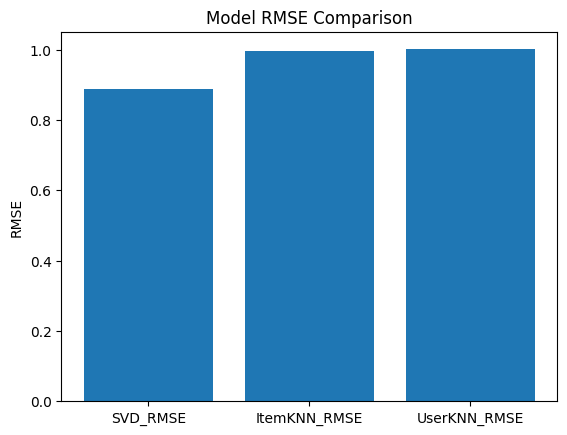

In [10]:
# Comparing models
results = {
    "SVD_RMSE": accuracy.rmse(pred_svd, verbose=False),
    "ItemKNN_RMSE": accuracy.rmse(pred_knn_item, verbose=False),
    "UserKNN_RMSE": accuracy.rmse(pred_knn_user, verbose=False)
}

plt.bar(results.keys(), results.values())
plt.title("Model RMSE Comparison")
plt.ylabel("RMSE")
plt.show()

In [7]:
# Hybrid Model (SVD + User-Based KNN)
def hybrid_recommend(user_id, top_n=5, alpha=0.7):
    """
    Hybrid recommender combining SVD + Item-KNN
    alpha = weight for SVD (0-1), rest for KNN
    """
    # Get all product IDs
    all_products = df["productId"].unique()
    user_rated = df[df["userId"] == user_id]["productId"].unique()

    scores = []
    for prod in all_products:
        if prod in user_rated:
            continue
        # Predict with SVD and KNN
        pred_svd = svd.predict(user_id, prod).est
        pred_knn = knn_item.predict(user_id, prod).est
        # Weighted score
        final_score = alpha * pred_svd + (1 - alpha) * pred_knn
        scores.append((prod, final_score))

    # Sort by score
    scores = sorted(scores, key=lambda x: x[1], reverse=True)[:top_n]
    return scores

In [8]:
# Sample prediction
sample_user = df["userId"].iloc[0]
print(f"Recommendations for User {sample_user}:")
print(hybrid_recommend(sample_user, top_n=10))


Recommendations for User A3LDPF5FMB782Z:
[('B00D6XW62I', 4.996206007948782), ('B00006HSYC', 4.985941539286498), ('B0000511U7', 4.961933462429488), ('B00316263Y', 4.934998210572301), ('B002QUZM0U', 4.9312784178034), ('B002NO7PWC', 4.915272322706539), ('B003WV5DJC', 4.906793186108618), ('B001BTCSI6', 4.901140495428676), ('B008LTBITY', 4.889390536240981), ('B00B50CEH6', 4.877532650305024)]


In [9]:
# Popularity based recommendation for cold start
popularity = df.groupby("productId")["Rating"].mean().sort_values(ascending=False).head(10)
print("Top 10 Popular Products:\n", popularity)

Top 10 Popular Products:
 productId
B00LGQ6HL8    5.0
B003DZJQQI    5.0
B005FDXF2C    5.0
B00I6CVPVC    5.0
B00B9KOCYA    5.0
B003CK10DG    5.0
B003B41XYO    5.0
B0007WK8KS    5.0
B0084FM5JC    5.0
B005GI2VMG    5.0
Name: Rating, dtype: float64
